In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model

from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

%matplotlib inline

### Import original data

In [2]:
Salary = pd.read_csv('./Kaggle_Salary.csv')

/home/hanwen/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1,3,9,11,13,22,24,25,26,27,28,29,45,57,65,84,86,88,108,110,124,126,151,195,209,224,250,263,265,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,305,307,323,326,327,330,342,372,385,386,394,395) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


After an overview of all the data and columns, we find that columns like "Unnamed: 0", "index" are irrelavent features to our task, so we just delete them.

Also, the titles of questions and column values like "Q1" are duplicated identifiers of features, so we delete title of questions because they are too long to handle with.

In [3]:
# Drop three irrelavent columns
Salary.drop(['Unnamed: 0','index'], axis=1,inplace=True)

QuestionMapping = {}
for col in Salary.columns:
    QuestionMapping[col] = Salary.loc[0,col]
Salary.drop([0],inplace=True)
print(Salary.shape)
Salary.head(3)

(15429, 395)


Time from Start to Finish (seconds)      Q1 Q1_OTHER_TEXT     Q2  \
1                                 434    Male            -1  30-34   
2                                 718  Female            -1  30-34   
3                                 731    Male            -1  22-24   

                         Q3                 Q4  \
1                 Indonesia  Bachelor’s degree   
2  United States of America    Master’s degree   
3                     India    Master’s degree   

                                              Q5              Q6  \
1             Engineering (non-computer focused)           Other   
2  Computer science (software engineering, etc.)  Data Scientist   
3                      Mathematics or statistics    Data Analyst   

  Q6_OTHER_TEXT                         Q7      ...       Q49_OTHER_TEXT  \
1             0  Manufacturing/Fabrication      ...                   -1   
2            -1             I am a student      ...                   -1   
3            -1             I am a student      ...                   -1   

  Q50_Part_1          Q50_Part_2 Q50_Part_3 Q50_Part_4  \
1        NaN                 NaN        NaN        NaN   
2        NaN  Too time-consuming        NaN        NaN   
3        NaN  Too time-consuming        NaN        NaN   

                               Q50_Part_5 Q50_Part_6 Q50_Part_7 Q50_Part_8  \
1                                     NaN        NaN        NaN        NaN   
2                                     NaN        NaN        NaN        NaN   
3  Not enough incentives to share my work        NaN        NaN        NaN   

  Q50_OTHER_TEXT  
1             -1  
2             -1  
3             -1  

[3 rows x 395 columns]

# Q1 Data Cleaning
In this step, we do data cleaning and featurization at the same time. We go through all the 50 questions in 394 columns one by one and handle different variables with different methods. 

#### Handle missing values
Based on the percentage of missing values in each column, we have several approaches to handling missing values.
- 1)If the percentage of missing values in the column is less than 1%, we delete the rows with nan value.
- 2)If the percentage of missing values in the column is between 1%~20%, we fill the nan value with mode of this column.
- 3)If the percentage of missing values in the column is between 20~50%, we fill the nan value with "Unknown".
- 4)If the percentage of missing values is above 50% which rarely happens in the dataset, we delete this column directly. Note that there are some binary columns with Yes/None value, we should excude these columns in this situation.

#### Handle general categorical features
For general categorical features that have no numerical order between different catagories, we convert categorical variable into dummy/indicator variables.

#### Handle special categorical features
There are some special categorical features like "Years of experience" which has values "1-2years","2-3years" etc. There is an inherent numerical sequence within the values, so we normalize each value with mean value, like 1.5, 2.5 etc.

#### Handle binary features
There are some questions that have been dummied in original data like "which programming language you are using". Each generated column is a yes-or-no question which has binary choices. For this kind of binary features, we label yes as '1' and NAN as '0'.

### Q1(a) Handle missing values
Based on the percentage of missing values in each column, we have several approaches to handling missing values.

`Approch and Justification` If the percentage of missing values in the column is less than 1%, since we have a total of 15429 observations which is large enough and 1% is a truly mini percentage, we choose to delete the rows with nan value directly.

`Impact` There are only two columns that has nan value less than 1%. We totally delete 210 rows among 15429 rows, which will have some kind bad effect on overall analysis but it's acceptable.

In [4]:
# See how many null values are in each column
# Here we only deal with those colunmns that has null values more than zero but fewer that 1% of all data
less_001 = []
for col in Salary.columns:
    NullNum = Salary[col].isnull().sum()
    if (NullNum > 0) & (0.01 * Salary.shape[0] > NullNum):
        if ("Part" not in col) or (col in ['Q39_Part_1','Q39_Part_2']):
            less_001.append(col)
print("We drop nan rows in the below columns:",less_001)

for col in less_001:
    Salary.dropna(subset=[col],inplace=True)
print(Salary.shape)

We drop nan rows in the below columns: ['Q5', 'Q8']
(15219, 395)


`Approch and Justification` If the percentage of missing values in the column is between 1%~20%, since mode is representative of the value of this column, we fill the nan value with mode of this column.

`Impact` There are seven columns that have nan value between 1%~20%. It will make bad effect on our overall analysis, but it's better than dropping directly. Considering there are more than 80% valid values which can show to some extent the distribution of values in this column, using the representative value "mode" is acceptable.

In [5]:
between_001_020 = []
for col in Salary.columns:
    NullNum = Salary[col].isnull().sum()
    if (0.2 * Salary.shape[0] > NullNum) and (NullNum >= 0.01 * Salary.shape[0]):
        if ("Part" not in col) or (col in ['Q39_Part_1','Q39_Part_2']):
            between_001_020.append(col)
print("We use modes in these columns to replace nan value:",between_001_020)
for col in between_001_020:
    Salary[col].fillna(Salary[col].mode()[0],inplace=True)

We use modes in these columns to replace nan value: ['Q10', 'Q12_MULTIPLE_CHOICE', 'Q18', 'Q23', 'Q24', 'Q25', 'Q26']


`Approch and Justification` If the percentage of missing values in the column is between 20~50%, since it's a relatively large proportion, we fill the nan value with a new identifier "Unknown".

`Impact` There are ten columns that have nan value between 20%~50%. Filling them with 'Unknown' will make some bad effect on our overall analysis, but it's better than filling with mode directly. It will add variation to these feature. But since this can help maintain these features, it is acceptable.

In [6]:
between_020_050 = []
for col in Salary.columns:
    NullNum = Salary[col].isnull().sum()
    if (0.2 * Salary.shape[0]) < NullNum and (NullNum < 0.5 * Salary.shape[0]):
        if ("Part" not in col) or (col in ['Q39_Part_1','Q39_Part_2']):
            between_020_050.append(col)
print("We set nans in these columns as 'Unknown':",between_020_050)

for col in between_020_050:
    Salary.loc[Salary[col].isnull(),col] = 'Unknown'

We set nans in these columns as 'Unknown': ['Q17', 'Q20', 'Q22', 'Q32', 'Q39_Part_1', 'Q39_Part_2', 'Q40', 'Q43', 'Q46', 'Q48']


`Approch and Justification` If the percentage of missing values is above 50% which rarely happens in the dataset, we delete this column directly. Note that there are some binary columns with Yes/None value, we should excude them in this situation. Having usefully information less than 50% is unacceptable because it loses much. We shouldn't fill nan with mode or other statistic value because they are deduced from less than 50% values thus not typical. Filling them with "Unknown" means giving same value to each observation at this feature, which will deteriorate further analysis. So we choose to delete it.

`Impact` In addition to binary columns, there is only one column that has nan value above 50%, thus deleting it would make a little bad effect but it is acceptable.

In [7]:
more_050 = []
for col in Salary.columns:
    NullNum = Salary[col].isnull().sum()
    if 0.5 * Salary.shape[0] < NullNum:
        if ("Part" not in col) or (col in ['Q39_Part_1','Q39_Part_2']):
            more_050.append(col)
print("We drop these columns because large part of the data is missing:",more_050)

for col in more_050:
    Salary.drop([col], axis=1,inplace=True)

We drop these columns because large part of the data is missing: ['Q37']


### Q1 (b) Handle general categorical features
For general categorical features, we convert categorical variable into dummy/indicator variables.

We go through all the questions and pick those that we can do general get_dummies operation on.

In [8]:
ALLCOL = Salary.columns.tolist()
def select_col(condition, allcol=ALLCOL):
    digit = len(condition)
    selected = []
    for i in allcol:
        if condition in i:
            if len(i)==digit:
                selected.append(i)
            elif i[digit] not in '0123456789':
                selected.append(i)                
    return selected

DummyCols = ['Q1','Q4','Q5','Q6','Q7','Q10','Q12_MULTIPLE_CHOICE',\
            'Q17','Q18','Q20','Q23','Q26','Q32','Q39_Part_1', 'Q39_Part_2',\
             'Q40','Q48']
for col in DummyCols:
    Salary = pd.get_dummies(data=Salary, columns=[col])

For 'Q3' 'In which country do you currently reside?', there are a total of 58 countries ranging from total number 3376 to 33. So before getting dummies, we eliminate categories by setting a threshold 50. The countries which have a total number fewer than 50 are changed to 'Other'.

In [9]:
# print(Salary['Q3'].value_counts())
val_counts = Salary['Q3'].value_counts()
value_mask = Salary['Q3'].isin(val_counts.index[val_counts < 50])
Salary.loc[value_mask,'Q3'] = "Other"

Salary = pd.get_dummies(data=Salary, columns=['Q3'])

For 'Q22' 'Of the choices that you selected in the previous question, which specific data visualization library or tool have you used the most? - Selected Choice', there are a total of 13 categories whose total number ranging from 6113 to 8. So before getting dummies, we eliminate categories by setting a threshold 100. The categories which have a total number fewer than 100 are changed to 'Other'.

In [10]:
# print(Salary['Q22'].value_counts())
val_counts = Salary['Q22'].value_counts()
value_mask = Salary['Q22'].isin(val_counts.index[val_counts < 100])
Salary.loc[value_mask,'Q22'] = "Other"

Salary = pd.get_dummies(data=Salary, columns=['Q22'])

### Q1 (c) Handle special categorical features
There are some special categorical features like "Years of experience" which has values "1-2years","2-3years" etc. There is an inherent numerical sequence within the values, therefore we normalize each value with mean value, like 1.5, 2.5 etc.

For Question2, 'What is your age (# years)?', Question8 'How many years of experience do you have in your current role?', Question24 'How long have you been writing code to analyze data?' and Question25 'For how many years have you used machine learning methods (at work or in school)?' Question43 'Approximately what percent of your data projects involved exploring unfair bias in the dataset and/or algorithm?', there is a numerical sequence between years and converting them directly with getting dummies will lose this kind of information. That's why we do normalization.

In [11]:
def Range_Normalize(value):
    if isinstance(value, str):
        if '-' in value:
            temp = value.split('-')
            return (float(temp[0])+float(temp[1]))/2
        if '+' in value:
            a = value.split('+')
            return float(a[0])
        else:
            return value
    else:
        return value

In [12]:
# Salary[select_col('Q2')]
Salary['Q2_NORMAL'] = Salary['Q2'].apply(Range_Normalize)
Salary.drop(['Q2'],axis=1,inplace=True)

# Salary[select_col('Q8')]
Salary['Q8_NORMAL'] = Salary['Q8'].apply(Range_Normalize)
Salary.drop(['Q8'],axis=1,inplace=True)

In [13]:
# Salary[select_col('Q24')]
def Q24Range_Normalize(value):
    mapdict = {'I have never written code and I do not want to learn':-1,
               'I have never written code but I want to learn':0,'< 1 year':0.5,
              '1-2 years':1.5,'3-5 years':4,'5-10 years':7.5,'10-20 years':15,
               '20-30 years':25,'30-40 years':35,'40+ years':40}
    return mapdict[value]
# Salary[select_col('Q2')]
Salary['Q24_NORMAL'] = Salary['Q24'].apply(Q24Range_Normalize)
Salary.drop(['Q24'],axis=1,inplace=True)

In [14]:
# Salary[select_col('Q25')]
Salary['Q25'].unique()
def Q25Range_Normalize(value):
    mapdict = {'I have never studied machine learning and I do not plan to':-1,
               'I have never studied machine learning but plan to learn in the future':0,
               '< 1 year':0.5,'1-2 years':1.5,'2-3 years':2.5,'3-4 years':3.5,'4-5 years':4.5,
               '5-10 years':7.5,'10-15 years':12.5,'20+ years':20}
    return mapdict[value]

Salary['Q25_NORMAL'] = Salary['Q25'].apply(Q25Range_Normalize)
Salary.drop(['Q25'],axis=1,inplace=True)

In [15]:
def Q41Range_Normalize(value):
    mapdict = {'Very important':10,
               'Slightly important':5,
               'No opinion; I do not know':2,
               'Unknown':0,
               'Not at all important':-10}
    return mapdict[value]

Salary.loc[Salary['Q41_Part_1'].isnull(),'Q41_Part_1'] = 'Unknown'
Salary.loc[Salary['Q41_Part_2'].isnull(),'Q41_Part_2'] = 'Unknown'
Salary.loc[Salary['Q41_Part_3'].isnull(),'Q41_Part_3'] = 'Unknown'

Salary['Q41_Part_1_NORMAL'] = Salary['Q41_Part_1'].apply(Q41Range_Normalize)
Salary.drop(['Q41_Part_1'],axis=1,inplace=True)
Salary['Q41_Part_2_NORMAL'] = Salary['Q41_Part_2'].apply(Q41Range_Normalize)
Salary.drop(['Q41_Part_2'],axis=1,inplace=True)
Salary['Q41_Part_3_NORMAL'] = Salary['Q41_Part_3'].apply(Q41Range_Normalize)
Salary.drop(['Q41_Part_3'],axis=1,inplace=True)

In [16]:
def Q43Range_Normalize(value):
    if isinstance(value, str):
        if '-' in value:
            temp = value.split('-')
            return (float(temp[0])+float(temp[1]))/2
        elif value == "0":
            return 0
        else:
            return float("nan")
    else:
        return value
Salary['Q43_NORMAL'] = Salary['Q43'].apply(Q43Range_Normalize)
Salary.drop(['Q43'],axis=1,inplace=True)
Salary['Q43_NORMAL'].fillna(Salary['Q43_NORMAL'].mode()[0],inplace=True)

Salary['Q46_NORMAL'] = Salary['Q46'].apply(Q43Range_Normalize)
Salary.drop(['Q46'],axis=1,inplace=True)
Salary['Q46_NORMAL'].fillna(Salary['Q46_NORMAL'].mode()[0],inplace=True)

### Q1 (d) Handle binary features
There are some questions that have been dummied in original data like "which programming language you are using". Each generated column is a yes-or-no question which has exclusive choice. For this kind of binary features, we label yes as '1' and NAN as '0'.

In [17]:
# Salary[select_col('Q11')]
import math
def Binarize(value):
    if isinstance(value,str):
        return 1
    else:
        if value == 0 or math.isnan(value):
            return 0
        else:
            return 1
def binarize_col(columns, data=Salary):
    for col in columns:
        data[col] = data[col].apply(Binarize)

In [18]:
NormalCols = select_col('Q11_Part') + select_col('Q13_Part') + \
select_col('Q14_Part') + select_col('Q15_Part') + select_col('Q16_Part')\
+ select_col('Q19_Part') + select_col('Q21_Part') + select_col('Q27_Part')\
+ select_col('Q28_Part') + select_col('Q29_Part') + select_col('Q30_Part') +\
select_col('Q31_Part') + select_col('Q33_Part') + select_col('Q34_Part') +\
select_col('Q36_Part') + select_col('Q38_Part') + select_col('Q42_Part') + \
select_col('Q44_Part') + select_col('Q45_Part') + select_col('Q47_Part') + \
select_col('Q49_Part') + select_col('Q50_Part')

binarize_col(NormalCols)

In [19]:
import math
def TBinarize(value):
    if isinstance(value,str):
        return float(value)
    else:
        if math.isnan(value):
            return -1
        else:
            return value
def Tbinarize_col(columns, data=Salary):
    for col in columns:
        data[col] = data[col].apply(TBinarize)

Tbinarize_col(select_col('Q34_Part'))
Tbinarize_col(select_col('Q35_Part'))

In [20]:
for col in Salary.columns:
    if isinstance(Salary.loc[1,col],str):
        Salary[col] = Salary[col].apply(lambda x:float(x))
Salary.rename(columns={"Q9": "Yearly_compensation"},inplace=True)
Salary.rename(columns={"Time from Start to Finish (seconds)": "TimeUse"},inplace=True)
Salary.drop(Salary[Salary.TimeUse < 180].index,inplace=True)
Salary.head(3)

TimeUse  Q1_OTHER_TEXT  Q6_OTHER_TEXT  Q7_OTHER_TEXT  Yearly_compensation  \
1    434.0           -1.0            0.0           -1.0              18668.0   
2    718.0           -1.0           -1.0           -1.0               2726.0   
3    731.0           -1.0           -1.0           -1.0                682.0   

   Q11_Part_1  Q11_Part_2  Q11_Part_3  Q11_Part_4  Q11_Part_5     ...      \
1           0           0           0           0           0     ...       
2           1           0           0           0           0     ...       
3           0           0           0           0           0     ...       

   Q22_ggplot2  Q2_NORMAL  Q8_NORMAL  Q24_NORMAL  Q25_NORMAL  \
1            0       32.0        7.5         0.0         0.0   
2            1       32.0        0.5         7.5         0.5   
3            0       23.0        0.5         7.5         2.5   

   Q41_Part_1_NORMAL  Q41_Part_2_NORMAL  Q41_Part_3_NORMAL  Q43_NORMAL  \
1                  0                  0                  0         0.0   
2                 10                 10                 10         5.0   
3                -10                  5                 10        25.0   

   Q46_NORMAL  
1        15.0  
2        15.0  
3        25.0  

[3 rows x 608 columns]

# Q2 Exploratory data analysis

In [21]:
# To visualize all the data, we reimport all the data.
SalaryVisual = pd.read_csv('./Kaggle_Salary.csv',header=1)
SalaryVisual.drop(['0','Duration (in seconds)','Unnamed: 396'], axis=1,inplace=True)

/home/hanwen/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (209,323,372,385,394) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
SalaryTemp = pd.read_csv('./Kaggle_Salary.csv')
TempCol = SalaryTemp.columns.tolist()
def select_col(condition, allcol=TempCol):
    digit = len(condition)
    selected = []
    for i in allcol:
        if condition in i:
            if len(i)==digit:
                selected.append(i)
            elif i[digit] not in '0123456789':
                selected.append(i)                
    return selected
TempBinary = select_col('Q11_Part') + select_col('Q13_Part') + \
select_col('Q14_Part') + select_col('Q15_Part') + select_col('Q16_Part')\
+ select_col('Q19_Part') + select_col('Q21_Part') + select_col('Q27_Part')\
+ select_col('Q28_Part') + select_col('Q29_Part') + select_col('Q30_Part') +\
select_col('Q31_Part') + select_col('Q33_Part') + select_col('Q34_Part') +\
select_col('Q36_Part') + select_col('Q38_Part') + select_col('Q42_Part') + \
select_col('Q44_Part') + select_col('Q45_Part') + select_col('Q47_Part') + \
select_col('Q49_Part') + select_col('Q50_Part')
tobinary = [SalaryTemp.loc[0,col] for col in TempBinary]
binarize_col(tobinary,data=SalaryVisual)

# Clean NAN value
less_001 = []
for col in SalaryVisual.columns:
    NullNum = SalaryVisual[col].isnull().sum()
    if (NullNum > 0) & (0.01 * SalaryVisual.shape[0] > NullNum):
        less_001.append(col)
for col in less_001:
    SalaryVisual.dropna(subset=[col],inplace=True)

SalaryVisual.drop([SalaryTemp.loc[0,'Q37']], axis=1,inplace=True)

between_020_050 = []
for col in SalaryVisual.columns:
    NullNum = SalaryVisual[col].isnull().sum()
    if (0.2 * SalaryVisual.shape[0]) < NullNum and (NullNum < 0.5 * SalaryVisual.shape[0]):
        between_020_050.append(col)
for col in between_020_050:
    SalaryVisual.loc[SalaryVisual[col].isnull(),col] = 'Unknown'

between_001_020 = []
for col in SalaryVisual.columns:
    NullNum = SalaryVisual[col].isnull().sum()
    if (0.2 * SalaryVisual.shape[0] > NullNum) and (NullNum >= 0.01 * SalaryVisual.shape[0]):
        between_001_020.append(col)
for col in between_001_020:
    SalaryVisual[col].fillna(SalaryVisual[col].mode()[0],inplace=True)

/home/hanwen/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1,3,9,11,13,22,24,25,26,27,28,29,45,57,65,84,86,88,108,110,124,126,151,195,209,224,250,263,265,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,305,307,323,326,327,330,342,372,385,386,394,395) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
mapcol = {'What is your gender? - Selected Choice':'Gender','What is your age (# years)?':'Age',
'In which country do you currently reside?':'ResidingCountry',
'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?':'EducationDegree',
'Select the title most similar to your current role (or most recent title if retired): - Selected Choice':'JobTitle',
'In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice':'EmploymentIndustry',
'Which best describes your undergraduate major? - Selected Choice':'Major',
'How many years of experience do you have in your current role?':'YearExperience',
'What is your current yearly compensation (approximate $USD)?':'YearlyCompensation',
'Approximately what percent of your time at work or school is spent actively coding?':'TimeSpendCoding',
'How long have you been writing code to analyze data?':'CodeDataAnalyze',
'For how many years have you used machine learning methods (at work or in school)?':'YearsML',
'Do you consider yourself to be a data scientist?':'SelfCog',
'What is the type of data that you currently interact with most often at work or school? - Selected Choice':'DataType',
'Approximately what percent of your data projects involve exploring model insights?':'PercentProject',
}

SalaryVisual.rename(columns=mapcol,inplace=True)

### Q2 (a)

Text(0,0.5,'Yearly Compensation')

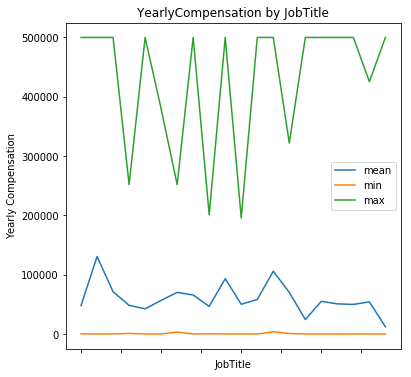

In [24]:
ax = SalaryVisual.groupby("JobTitle").YearlyCompensation.agg(['mean', 'min', 'max']).plot(figsize=(6,6),title="YearlyCompensation by JobTitle")
ax.set_ylabel("Yearly Compensation")

Text(0,0.5,'Yearly Compensation')

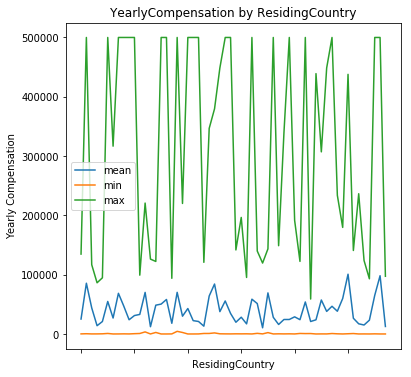

In [25]:
ax = SalaryVisual.groupby("ResidingCountry").YearlyCompensation.agg(['mean', 'min', 'max']).plot(figsize=(6,6),title="YearlyCompensation by ResidingCountry")
ax.set_ylabel("Yearly Compensation")

In the above figures, we respectively show the relationships between JobTitle and YearlyCompensation, ResidingCountry and YearlyCompensation. The mean and maximum YearlyCompensation vary with these two variables. Comparatively, the minimun yearlycompensations are almost the same. So we should keep these two features.

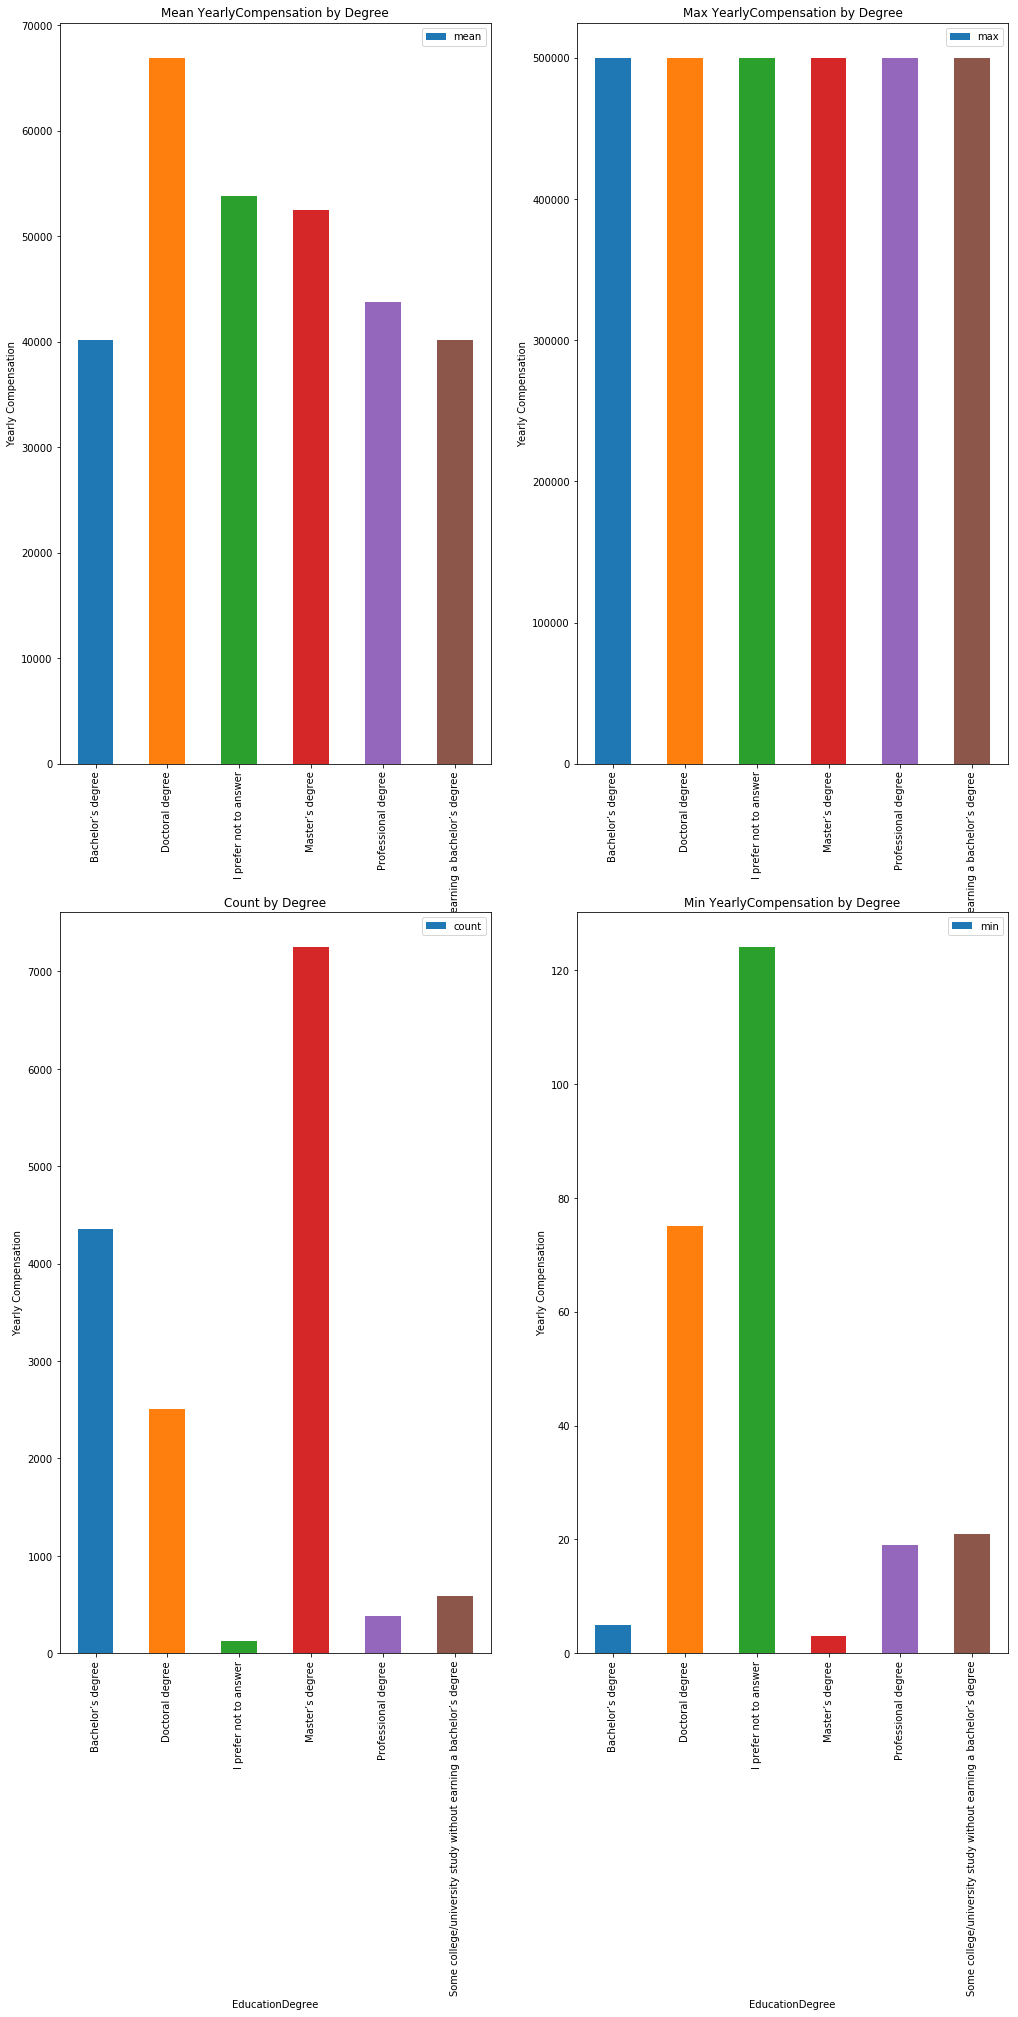

In [26]:
compensation_by_degree=SalaryVisual.groupby("EducationDegree").YearlyCompensation.agg(['count', 'mean', 'min', 'max'])
fig, axes = plt.subplots(nrows=2, ncols=2)
ax = compensation_by_degree.plot(y='mean',kind="bar",title="Mean YearlyCompensation by Degree",ax=axes[0,0],figsize=(17,30))
ax.set_ylabel("Yearly Compensation")
ax = compensation_by_degree.plot(y='max',kind="bar",title="Max YearlyCompensation by Degree",ax=axes[0,1])
ax.set_ylabel("Yearly Compensation")
ax = compensation_by_degree.plot(y='count',kind="bar",title="Count by Degree",ax=axes[1,0])
ax.set_ylabel("Yearly Compensation")
ax = compensation_by_degree.plot(y='min',kind="bar",title="Min YearlyCompensation by Degree",ax=axes[1,1])
ax.set_ylabel("Yearly Compensation")
plt.show()

In the above figures, we respectively show mean,max,number and min YearlyCompensation of people with different degrees. According to mean value, we know that people with higher degree are more likely to earn more salary. The highest average is from Doctoral degree. We also notice that people with different degrees all have chance to earn salary as high as 500,000. There is also class-imbalance within degrees. Most people have master degree.
From the last figure we notice a weird phenomenon that some people earn as less as 100. These values are fake and unrealiable since respondents may take this survey slightly and give false value. 

Therefore, for furture prediction, we will delete the data whose salary is lower than a threshold.

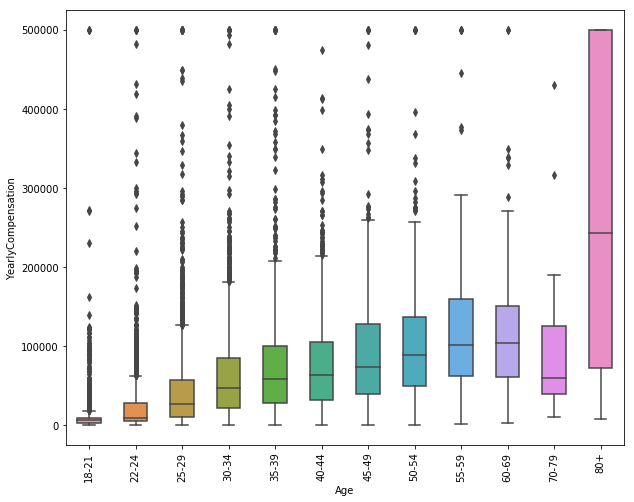

In [27]:
#box plot Age/salary
var = 'Age'
order=["18-21","22-24","25-29","30-34","35-39","40-44","45-49","50-54","55-59","60-69","70-79","80+"]
data = pd.concat([SalaryVisual['YearlyCompensation'], SalaryVisual[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 8))
fig = sns.boxplot(x=var, y="YearlyCompensation", data=SalaryVisual,width=0.5,order=order)
_ = fig.set_xticklabels(fig.get_xticklabels(),rotation=90)

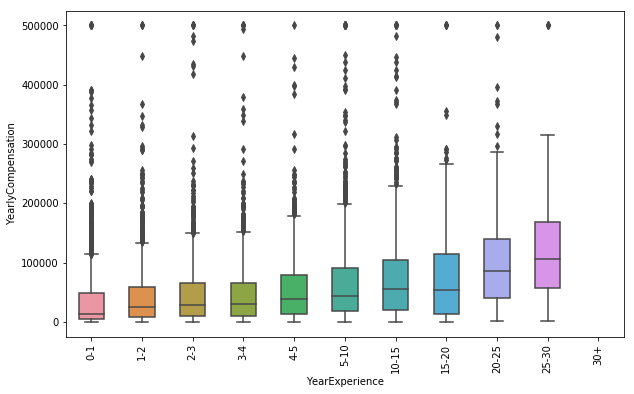

In [28]:
#box plot YearExperience/salary
var = 'YearExperience'
order=["0-1","1-2","2-3","3-4","4-5","5-10","10-15","15-20","20-25","25-30","30+"]
data = pd.concat([SalaryVisual['YearlyCompensation'], SalaryVisual[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x=var, y="YearlyCompensation", data=SalaryVisual,width=0.5,order=order)
_ = fig.set_xticklabels(fig.get_xticklabels(),rotation=90)

In the above figures, we try to digit into the relationship between YearlyCompensation and work experience, so we respectively show the relationships between Age and YearlyCompensation, YearExperience and YearlyCompensation. Based on the compensation distribution, we can conclude that older people or those who have longer work experience are more likely to have a higher yearlycompensation. Therefore we need to keep these two features for regression.

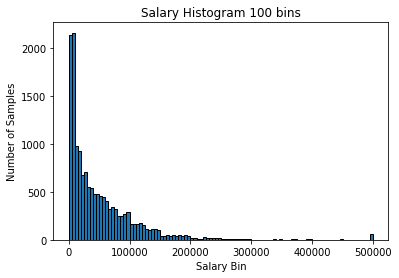

In [29]:
%matplotlib inline

plt.hist(SalaryVisual['YearlyCompensation'], bins=100, edgecolor='black')
plt.title("Salary Histogram 100 bins")
plt.xlabel("Salary Bin")
plt.ylabel("Number of Samples")
plt.show()

The primary concern for further regression task is existance of outliers in our dataset, so we draw a Histogram showing the distribution of yearly compensation. From 0 to 300,000 the number of persons keeps droping. But it's weird that there is a minor peak at 500,000. We have reason to doubt the authentication of these data records. Maybe some respondents blindly choose the largest value. Therefore, for future regression task, we will set a threhold to eliminate the outliers.

### Q2 (b) Visualize the order of feature importance

Pearson is the most widely used correlation coefficient, which measures the linear association between continuous variables. In other words, this coefficient quantifies the degree to which a relationship between two variables can be described by a line. Here we use Pearson coefficient to measure the correlation between all the features in our dataset and plot correlation of features with YearlyCompensation.

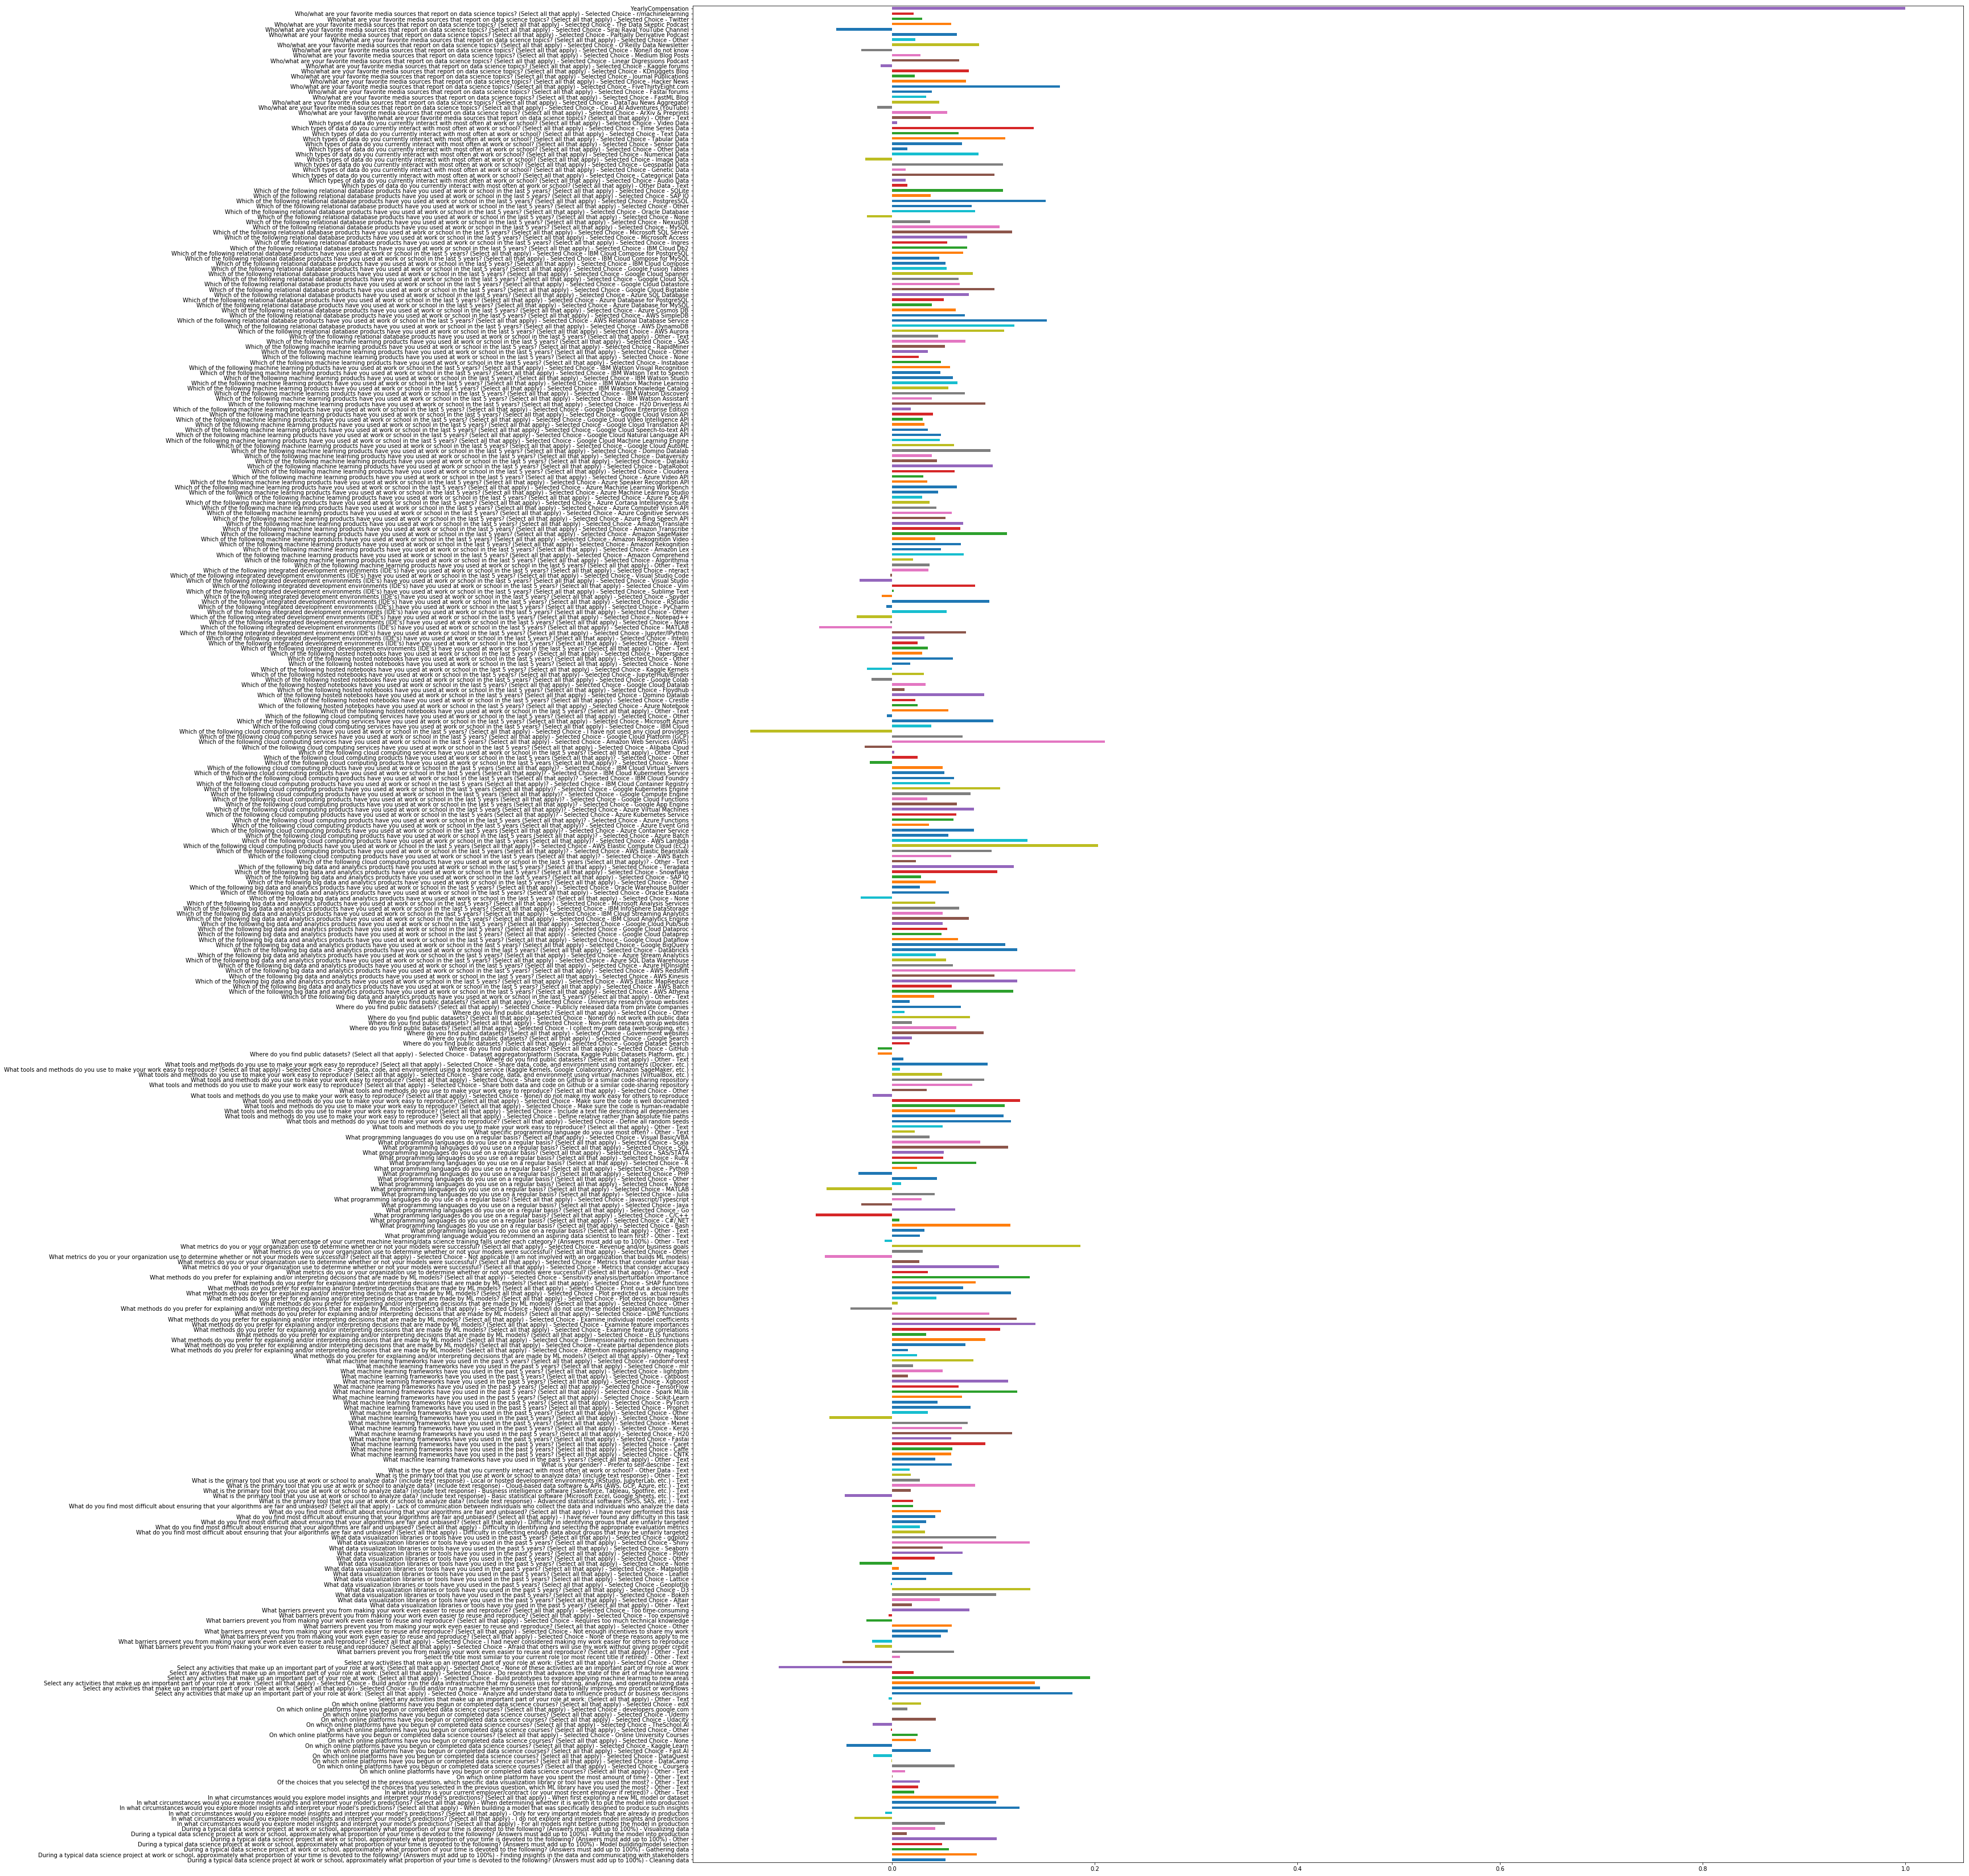

In [30]:
for col in SalaryVisual.columns:
    if len(SalaryVisual[col].value_counts())==1:
        SalaryVisual.drop([col], axis=1,inplace=True)

corr = SalaryVisual.corr()
(corr.YearlyCompensation.sort_index().plot(kind="barh",figsize=(40,60)))

The computation of Pearson coefficient ρ ensures that result will always fall between -1 and 1. The closer ρ is to 1, the more an increase in one variable associates with an increase in YearlyCompensation. On the other hand, the closer ρ is to -1, the increase in one variable would result in decrease in YearlyCompensation. If a certain variable and YearlyCompensation are independent, then ρ is close to 0. Therefore, we use the absolute value of pearson coefficient to measure the importance of this variable.

Text(0,0.5,'Absolute correlation with YearlyCompensation')

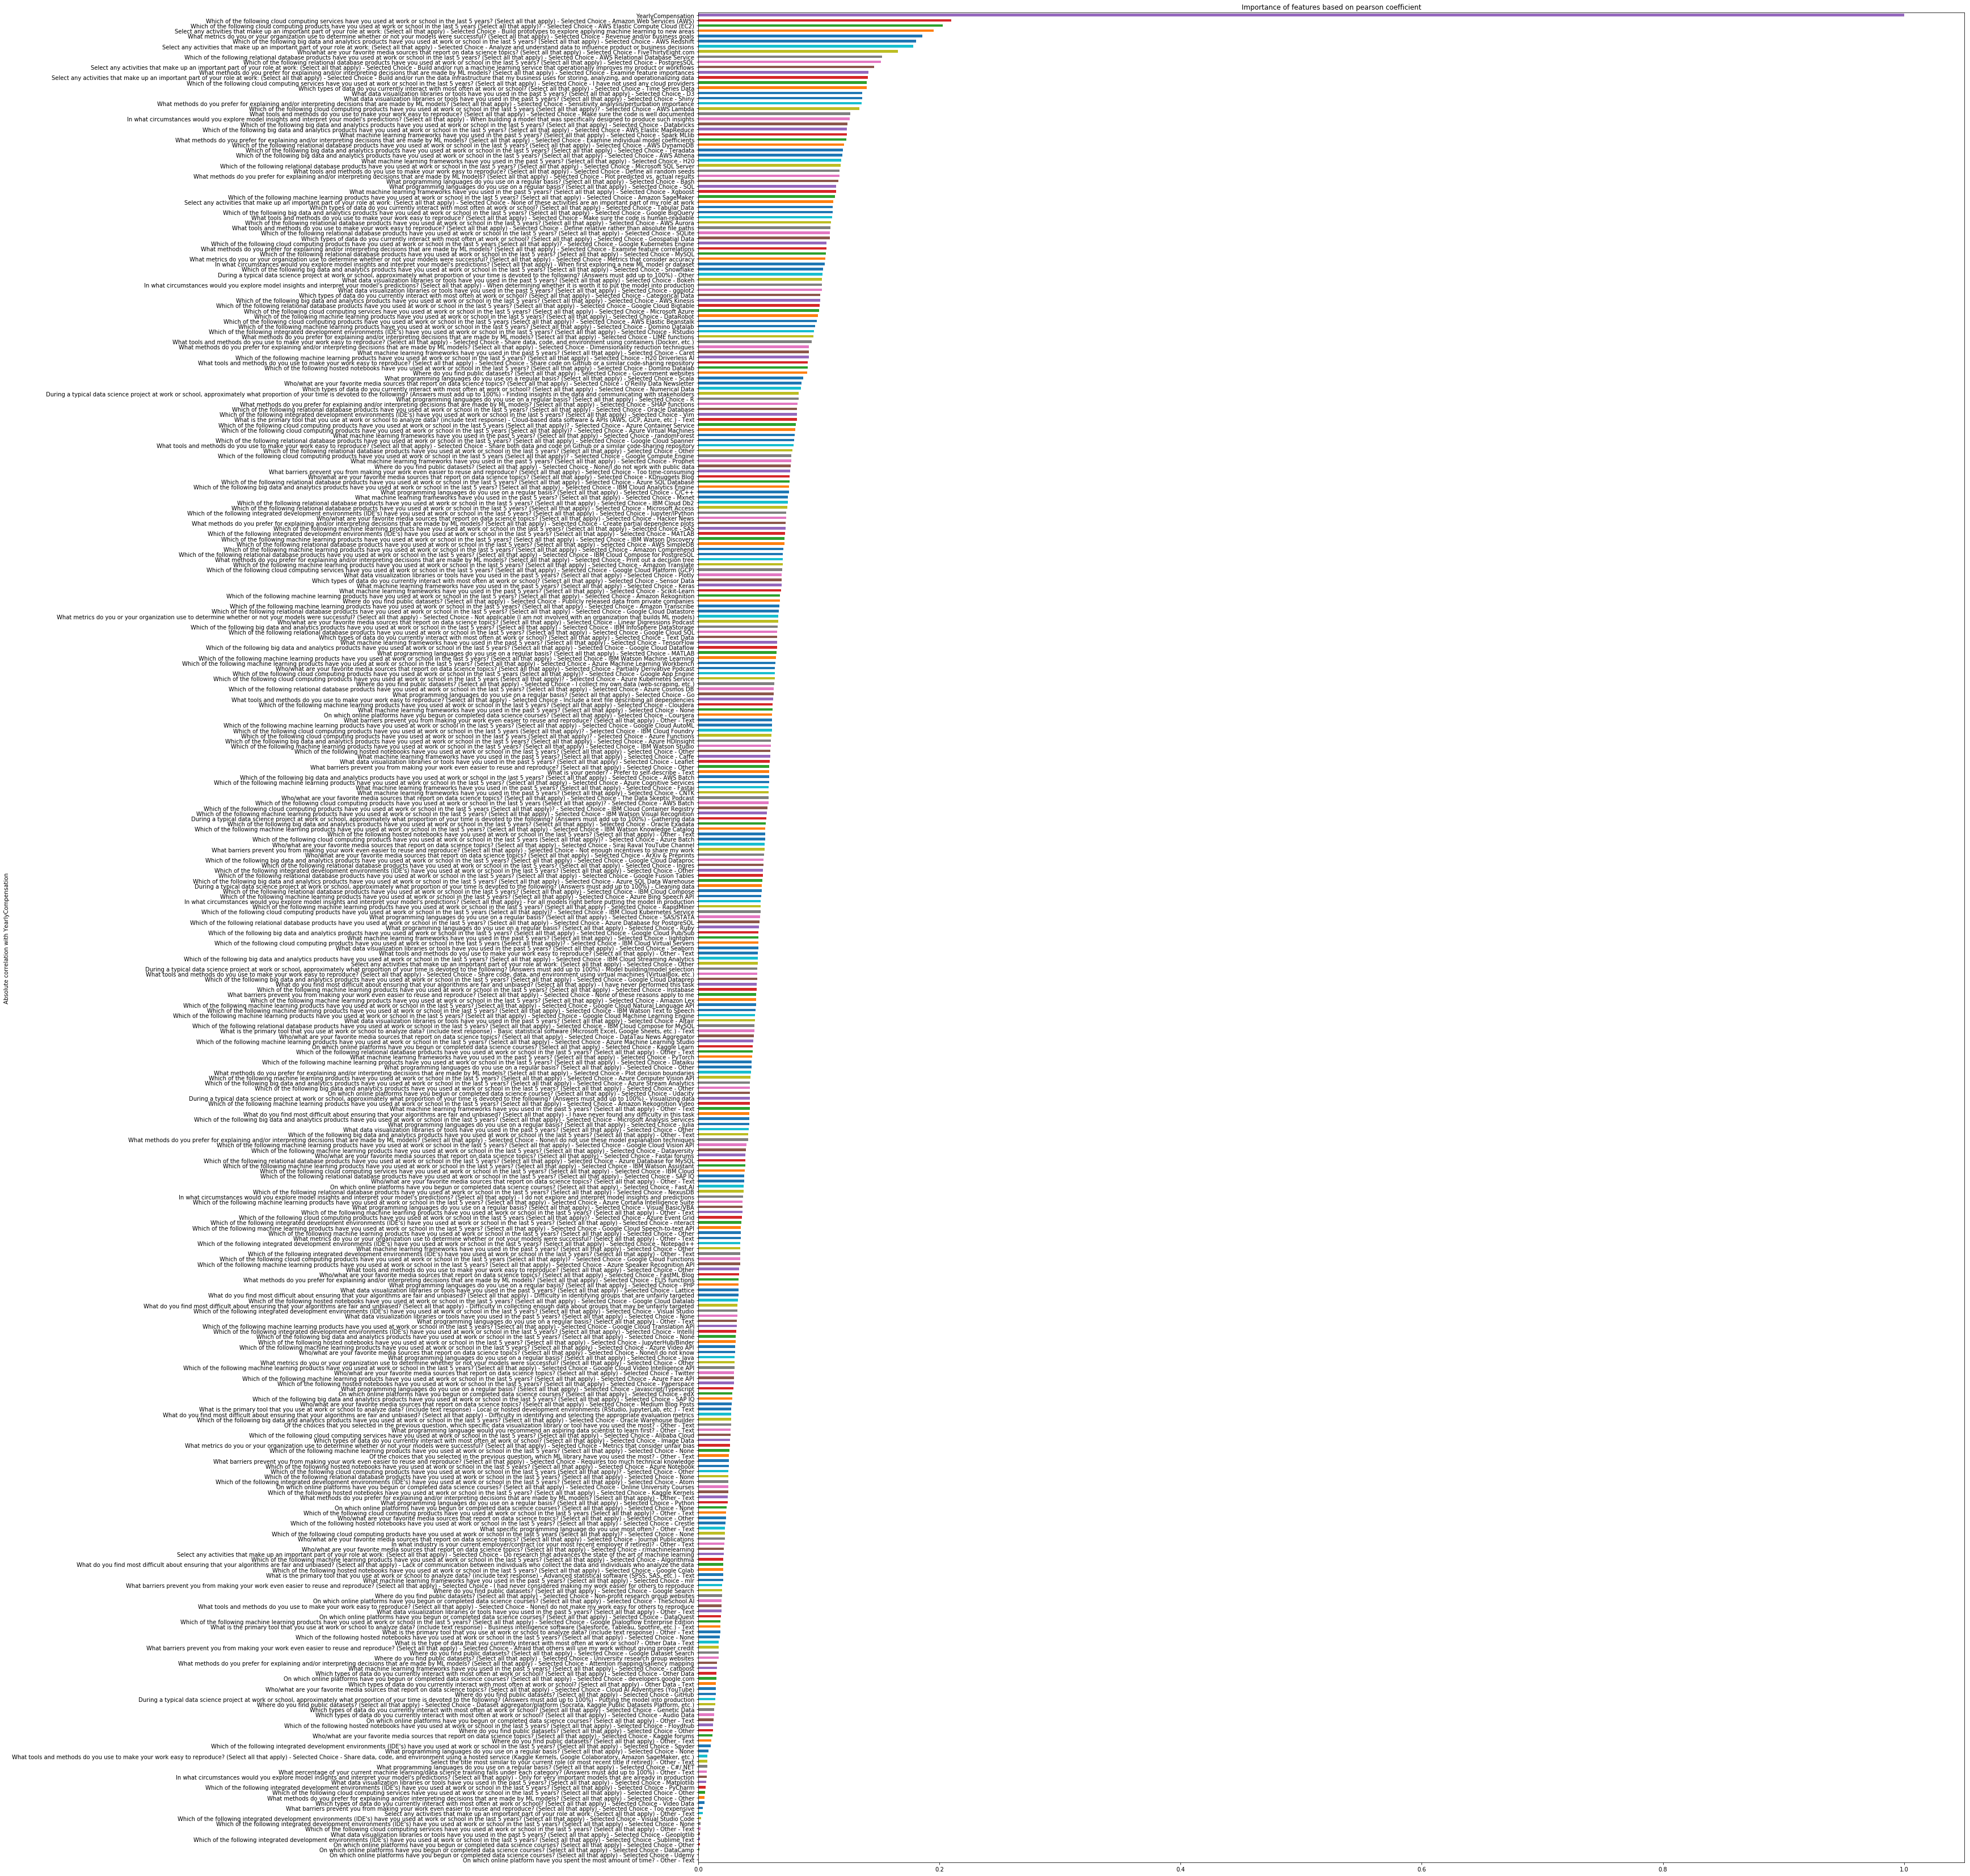

In [31]:
correlation = corr.YearlyCompensation.apply(lambda x: abs(x)).sort_values()
ax = (correlation.plot(kind="barh",figsize=(40,60),title="Importance of features based on pearson coefficient"))
ax.set_ylabel('Absolute correlation with YearlyCompensation')

In [32]:
print("TOP 5 most important features according to correlation with YearlyCompensation:")
print(correlation.sort_values(ascending=False)[1:6],"\n")

print("TOP 5 less important features according to correlation with YearlyCompensation:")
print(correlation.sort_values(ascending=False)[-5:])

TOP 5 most important features according to correlation with YearlyCompensation:
Which of the following cloud computing services have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice - Amazon Web Services (AWS)                   0.209691
Which of the following cloud computing products have you used at work or school in the last 5 years (Select all that apply)? - Selected Choice - AWS Elastic Compute Cloud (EC2)             0.203011
Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build prototypes to explore applying machine learning to new areas    0.195176
What metrics do you or your organization use to determine whether or not your models were successful? (Select all that apply) - Selected Choice - Revenue and/or business goals              0.185821
Which of the following big data and analytics products have you used at work or school in the last 5 years? (Select all that app

We can learn from above that the top 5 most important features according to pearson coefficent with YearlyCompensation is:
- Use or not use AWS in the past
- Use or not use EC2 in the past
- Build prototypes to explore applying machine learning to new areas in work
- Use Revenue and/or business goals to determine the success of work
- Use AWS Redshift product at work in the past

We can learn from above that the top 5 less important features according to pearson coefficent with YearlyCompensation is:
- On "Other" area to spend most amount of time
- Use Udemy as online platform to take data science courses
- Use DataCamp as online platform to take data science courses
- Use Other online platform to take data science courses
- Use SublimeText development environments in work in the past

According to data visualization, we remove records that has YearlyCompensation above 350,000 or below 1,000.

In [33]:
for col in Salary.columns:
    if len(Salary[col].value_counts())==1:
        Salary.drop([col], axis=1,inplace=True)

Salary.drop(Salary[Salary.Yearly_compensation < 1000].index, inplace=True)
Salary.drop(Salary[Salary.Yearly_compensation > 350000].index, inplace=True)

In [34]:
for col in Salary.columns: 
    if Salary[col].isna().any():
        print(col)

for col in Salary.columns: 
    if isinstance(Salary.loc[1,col],str):
        print(col)

In [35]:
X = Salary.drop(['Yearly_compensation'],axis=1)
Y = Salary['Yearly_compensation']

from sklearn.model_selection import train_test_split
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X,Y,test_size=0.3, random_state=20)

#### After cleaning data, we have data of size below:

In [36]:
print(X.shape,X_Train.shape)

(13995, 605) (9796, 605)


# Q3 Feature selection

Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work better. If feature engineering is done correctly, it increases the predictive power of machine learning algorithms by creating features from raw data that help facilitate the machine learning process. Feature engineering can be valuable since we can isolate and highlight key information, which helps our algorithms "focus" on what’s important. We can also bring in our own domain expertise.

In [37]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def feature_scaling(X_Train, X_Test, method):
    methodmap = {'z-score':StandardScaler(),'min-max':MinMaxScaler(),'robust':RobustScaler()}
    if method not in ['z-score','min-max','robust']:
        print("We don't have this kind of method for normalization. Please choose from ['z-score','min-max','robust']")
        return pd.DataFrame(X_Train), pd.DataFrame(X_Test)
    else:
        ss = methodmap[method].fit(X_Train)
        X_Train = ss.transform(X_Train)
        X_Test = ss.transform(X_Test)
        return pd.DataFrame(X_Train), pd.DataFrame(X_Test)

X_Train_All, X_Test_All = feature_scaling(X_Train,X_Test,'z-score')

#### We design a function that could implement four feature selection methods "variable variance", "mutual information", "PCA", "select from lasso model". Due to computation complexity, we present two classic methods "PCA", "select from lasso model" and compare their performance to choose better feature set.

In [38]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

def feature_elimination(X_Train, X_Test, Y_Train, method='pca', para=None):
    if method not in ['variance','pca','mul_info','lassocv']:
        print("We don't have this kind of method for normalization. Please choose from ['variance','pca','mul_info']")
        return X_Train, X_Test
    else:
        if method=='variance':
            Para = para if para else (.008 * (1 - .008))
            sel = VarianceThreshold(threshold = Para).fit(X_Train)
            X_Train = sel.transform(X_Train)
            X_Test = sel.transform(X_Test)
            return pd.DataFrame(X_Train), pd.DataFrame(X_Test)
        elif method=='mul_info':
            Para = para if para else 200
            sel = SelectKBest(mutual_info_classif, k=Para).fit(X_Train,Y_Train)
            X_Train = sel.transform(X_Train)
            X_Test = sel.transform(X_Test)
            return pd.DataFrame(X_Train), pd.DataFrame(X_Test)
        elif method=='lassocv':
            clf = LassoCV(cv=5)
            sfm = SelectFromModel(clf, threshold=0.25)
            sfm.fit(X_Train, Y_Train)
            X_Train = sfm.transform(X_Train)
            X_Test = sfm.transform(X_Test)
            return pd.DataFrame(X_Train), pd.DataFrame(X_Test)
        else:
            Para = para if para else 200
            sel = PCA(n_components=Para).fit(X_Train)
            X_Train = sel.transform(X_Train)
            X_Test = sel.transform(X_Test)
            return pd.DataFrame(X_Train), pd.DataFrame(X_Test)

In [39]:
PX_Train, PX_Test = feature_elimination(X_Train_All,X_Test_All,Y_Train,'pca')

Principal Component Analysis(PCA) tries to find the directions of most variation in the dataset. Since the dimensionality of our feature set is too large, using PCA we can identify what are the most important dimensions and just keep part of them to explain most of the variance we see in our data. We can drastically reduce the dimensionality of the data. Moreover, it also enables us to identify what the most important variables in the original feature space are. Thus we use pca to extract top 200 high variance dimensions.

In [40]:
LX_Train, LX_Test = feature_elimination(X_Train_All,X_Test_All,Y_Train,'lassocv')

We use SelectFromModel method from sklearn to do feature selection. This method could return the non-zero coefficients from linear models penalized with L1 norm and here we choose Lasso considering its linear property and l1 regulization. It can help us to get an insight to the resulting coefficients of the features returned by lasso models to see which ones have a positive or negative relationship with the YearlyCompensation. By setting a threshold value, features whose importance is greater or equal are kept while the others are discarded.

# Q4 Model Implementation
#### At this step, we develop a class "Regressor" that could implement five different algorithms, which are "LinearRegression", "Lasso", "ElasticNet", "RandomForest", "GradientBoosting". In Q3, we obtained two bunches of features "PCA" and "SelectLasso". So here we respectively apply five methods on two kinds of features to choose the better feature bunch. Then comparing the results based on better features, we choose the best model.

In [41]:
from collections import OrderedDict

from sklearn.linear_model import LinearRegression as lr
from sklearn.linear_model import Lasso as lasso
from sklearn.linear_model import ElasticNet as elsnet
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import GradientBoostingRegressor as gbr

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.metrics import mean_squared_error, make_scorer, r2_score, mean_absolute_error
from sklearn.metrics import roc_auc_score, roc_curve, auc,confusion_matrix,accuracy_score

def bias(y_predict,y):
    y_predict = np.array(y_predict)
    y = np.array(y)
    avg = np.average(y_predict)
    return np.sqrt(np.average(np.power((avg-y),2)))
def variance(y_predict):
    y_predict = np.array(y_predict)
    return np.sqrt(np.var(y_predict))

def two_score(y_true,y_pred):    
    mean_squared_error(y_true,y_pred) #set score here and not below if using MSE in GridCV
    score = r2_score(y_true,y_pred)
    return score

def run_kfold(model,X,y,folds=10):
    kf = KFold(n_splits=folds)
    kf.get_n_splits(X)
    score_keep = []
    trade_keep = []
    fold = 0
    print("The result with {}-fold cross-validation on training set".format(folds))

    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)

        train_r2 = r2_score(y_train, y_train_predict)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_predict))
        train_mae = mean_absolute_error(y_test, y_test_predict)
        
        test_r2 = r2_score(y_test, y_test_predict)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_predict))
        test_mae = mean_absolute_error(y_test, y_test_predict)
        # print("Fold {} R2 training score: {}, testing score: {}".format(fold,train_r2,test_r2))
        # print("RMSE training score: {}, testing score: {}".format(train_rmse,test_rmse))
        train_bia = bias(y_train_predict,y_train)
        train_var = variance(y_train_predict)
        train_total = train_bia + train_var
        
        test_bia = bias(y_test_predict,y_train)
        test_var = variance(y_test_predict)
        test_total = test_bia + test_var

        score_keep.append((train_r2, test_r2,train_rmse, test_rmse,train_mae,test_mae))
        trade_keep.append((train_bia,test_bia,train_var,test_var,train_total,test_total))
    score_df = pd.DataFrame(score_keep, columns=["train_R2","test_R2","train_RMSE","test_RMSE","train_MAE","test_MAE"])
    trade_df = pd.DataFrame(trade_keep, columns=["train_bia","test_bia","train_var","test_var","train_total","test_total"])
    print(score_df.describe()[["test_R2","test_RMSE","test_MAE"]][1:4])
    return clf, score_df, trade_df

class Regressor(object):
    def __init__(self,train_data,train_targets):
        super().__init__()
        self.train_data = train_data
        self.train_targets = train_targets
        rfrhyperpara = {'n_estimators': list(range(85,120,5)),'max_depth': list(range(45,60,3)),'min_samples_leaf': [1, 2, 3]}
        gbrhyperpara = {'n_estimators': list(range(90,120,5)),'max_depth': list(range(4,15,3)),'min_samples_leaf': [1, 2]}
        self.models=OrderedDict([('LinearRegression',[lr(),None]),\
                            ('Lasso',[lasso(alpha=9.0,max_iter=2000,random_state=20),dict(alpha=np.arange(5,15,0.5))]),\
                            ('ElasticNet',[elsnet(l1_ratio=0.8),dict(l1_ratio=np.linspace(0,1,10))]),\
                            ('RandomForest',[rfr(n_estimators = 105, max_depth=40, min_samples_leaf=2),rfrhyperpara]),\
                            ('GradientBoosting',[gbr(),gbrhyperpara])])
        #1.1 and 2.70 # ElasticNet(alpha=1.0, l1_ratio=0.5）
    def train_model(self,model_name,scorer="R2",ifhyper_tune=False,hyper_paras="",folder=10):
        self.model_name = model_name
        model = self.models[model_name][0]
        if ifhyper_tune:
            if not hyper_paras:
                hyper_paras = self.models[model_name][1]
            # Grid search method for hyper-parameter tuning in which we use 5-fold cross validation
            if hyper_paras:
                if scorer=='R2':
                    acc_scorer = make_scorer(r2_score)
                elif scorer == 'RMSE':
                    acc_scorer = make_scorer(mean_squared_error)
                else:
                    acc_scorer = make_scorer(two_score, greater_is_better=True)
                grid = GridSearchCV(model, hyper_paras, cv=5, scoring=acc_scorer, n_jobs=-1) 

                grid.fit(self.train_data, self.train_targets)
                print('The best score of model {} through {}-cross validation is {}, with the best hyper-parameter {}\n'\
                    .format(model_name, 5, grid.best_score_, grid.best_params_))

                # Best model
                best_model = grid.best_estimator_
            else:
                best_model = model.fit(self.train_data,self.train_targets)
            train_pred = best_model.predict(self.train_data)
            R2 = r2_score(self.train_targets,train_pred)
            print('Through Hypertuning on {}, we get the best model and the results below:'.format(model_name))
            print('The R2 score is {}'.format(R2))
            RMSE = np.sqrt(mean_squared_error(self.train_targets,train_pred))
            print('The RMSE score is {}'.format(RMSE))
            MAE = mean_absolute_error(self.train_targets,train_pred)
            print('The MAE score is {}'.format(MAE))
            score_df = pd.DataFrame([(R2,RMSE,MAE)], columns=["R2", "RMSE","MAE"])
        else:
            best_model, score_df, trade_df = run_kfold(model,self.train_data,self.train_targets,folder)
        
        self.best_model = best_model
        if ifhyper_tune:
            return best_model, score_df
        else:
            return best_model, score_df, trade_df

    def test_model(self,test_data,test_targets,new_best=None):
        if new_best is not None:
            test_pred = new_best.predict(test_data)
        else:
            test_pred = self.best_model.predict(test_data)
            print("Result of Model {} is list below:".format(self.model_name))
        R2 = r2_score(test_targets, test_pred)
        RMSE = np.sqrt(mean_squared_error(test_targets,test_pred))
        MAE = mean_absolute_error(test_targets,test_pred)
        BIAS = bias(test_pred,test_targets)
        VAR = variance(test_pred)
        TOTAL = BIAS + VAR
        # test accuracy
        print('R2 score is {}'.format(R2))
        print('RMSE socre is {}'.format(RMSE))
        print('MeanAbsoluteError is {}'.format(MAE))
        # print('Bias score is {}'.format(BIAS))
        # print('Variance score is {}'.format(VAR))
        # print('Bias+Variance score is {}'.format(TOTAL))
        return R2, RMSE, MAE, BIAS, VAR, TOTAL

##### For each algorithm, briefly talk about what it does, what its pros and cons are, and why you chose that algorithm.
- LinearRegression is a technique for predicting a dependent variable based on one or more independent variables. The term "linear" refers to the fact that the method models data as a linear combination of explanatory variables. It tries to fit a straight line to the response variable data so that the line minimizes the squared differences (also called errors or residuals) between the actual obbserved response and the predicted point on the line. 
`pros` It can work on any size of dataset and can give about the relevance of variables.
`cons` It assumes that independent variables have linear relationship with dependent variable, which is always not true in real life. `usage` We assume that most of the features are linearly related with 'YearlyCompensation' and it's a classic regression model so we use it.

- Lasso is similar to LinearRegression in that it also models data as a linear combination of explanatory variables. The difference is that it adds l1 regularizer to objective functions and tries to fit a straight line to the response variable data so that the line minimizes errors between the actual obbserved response and the predicted point on the line.
`pros` It can work on any size of dataset and can give about the relevance of variables. It uses l1 regularizer that encourages sparsity and works as a feature selector. `cons` It assumes that independent variables have linear relationship with dependent variable, which is always not true in real life. `usage` We assume that most of the features are linearly related with 'YearlyCompensation' and adding regularization can prevent overfitting.

- ElasticNet is similar to LinearRegression in that it also models data as a linear combination of explanatory variables. The difference is that it takes advantage of l1 and l2 regularizations at the same time and gives weight to balance them. It tries to fit a straight line to the response variable data so that the line minimizes errors between the actual obbserved response and the predicted point on the line.
`pros` It can work on any size of dataset and can give about the relevance of variables. It uses l1-penalty to help generating a sparse model and l2-part to overcome a strict selection `cons` It assumes that independent variables have linear relationship with dependent variable, which is always not true in real life. `usage` We assume that most of the features are linearly related with 'YearlyCompensation' and adding regularization can prevent overfitting.

- Random forest is a versatile algorithm and can be used for both regression and classification. It improves over the top of the decision tree algorithm and tries to generate multiple small decision trees from random subsets of the data. Then it combines the results from each of the decision tree to give the final unbiased prediction.
`pros` It works well on large datasets and can be used to extract variable importance. It does not require feature engineering (scaling and normalization). `cons` It would overfit in case of noisy data and unlike decision trees, results are difficult to interpret. Also, hyperparamters needs good tuning for high accuracy. `usage` It's one of the most accurate prediction model and Random forests have successfully been implemented in a variety of fields. SO we choose it.

- GradientBoostingTree is similar to Random Forests that generate multiple trees. Differently, Random Forest trains each tree independently while GBTs build trees one at a time, where each new tree helps to correct errors made by previously trained tree.
`pros` GBT often provides predictive accuracy that cannot be beat and has lots of flexibility about loss functions. It doesn't require data pre-processing and can handle missing data, `cons`GBT continues improving to minimize all errors which will cause overfitting. Must use cross-validation to neutralize and it's computationally expensive.`usage` It's one of the most accurate prediction model and has successfully been implemented in a variety of fields. The building trees strategy is different from RandomForest so we choose it.

#### Model implementation with Features from PCA

In [42]:
PcaFeatureReg = Regressor(PX_Train,Y_Train)

In [43]:
print('Result from LinearRegression:')
plr_model, plr_score, plr_trade = PcaFeatureReg.train_model('LinearRegression')

print('\nResult from ElasticNet:')
pelc_model, pelc_score, pelc_trade = PcaFeatureReg.train_model('ElasticNet')

print('\nResult from RandomForest:')
prfr_model, prfr_score, prfr_trade = PcaFeatureReg.train_model('RandomForest')

print('\nResult from GradientBoosting:')
pgdb_model, pgdb_score, pgdb_trade = PcaFeatureReg.train_model('GradientBoosting')

print('\nResult from Lasso:')
plasso_model, plasso_score, plasso_trade = PcaFeatureReg.train_model('Lasso')

Result from LinearRegression:
The result with 10-fold cross-validation on training set
       test_R2     test_RMSE      test_MAE
mean  0.504585  36385.268611  24985.537382
std   0.028555   1423.797183    668.839407
min   0.462134  33975.353210  24167.021655

Result from ElasticNet:
The result with 10-fold cross-validation on training set
       test_R2     test_RMSE      test_MAE
mean  0.505381  36360.055688  24830.968799
std   0.027078   1464.722531    665.894112
min   0.468144  34004.336284  23994.348134

Result from RandomForest:
The result with 10-fold cross-validation on training set
       test_R2     test_RMSE      test_MAE
mean  0.330818  42306.977638  29912.679960
std   0.022734   1624.363751    536.970535
min   0.292891  40685.514332  29207.994334

Result from GradientBoosting:
The result with 10-fold cross-validation on training set
       test_R2     test_RMSE      test_MAE
mean  0.387567  40481.930780  27916.286427
std   0.021022   1800.807543    612.990602
min   0.349582

#### Model implementation with Features from LassoSelection

In [44]:
LeFeatureReg = Regressor(LX_Train,Y_Train)

In [45]:
print('Result from LinearRegression:')
lr_model, lr_score, lr_trade = LeFeatureReg.train_model('LinearRegression')

print('\nResult from Lasso:')
lasso_model, lasso_score,lasso_trade = LeFeatureReg.train_model('Lasso')

print('\nResult from ElasticNet:')
elc_model, elc_score, elc_trade = LeFeatureReg.train_model('ElasticNet')

print('\nResult from RandomForest:')
rfr_model, rfr_score, rfr_trade = LeFeatureReg.train_model('RandomForest')

print('\nResult from GradientBoosting:')
gdb_model, gdb_score, gdb_trade = LeFeatureReg.train_model('GradientBoosting')

Result from LinearRegression:
The result with 10-fold cross-validation on training set
       test_R2     test_RMSE      test_MAE
mean  0.584582  33325.829170  22320.800607
std   0.022330   1422.097882    462.086330
min   0.556468  31677.198209  21582.429083

Result from Lasso:
The result with 10-fold cross-validation on training set
       test_R2     test_RMSE      test_MAE
mean  0.585777  33280.844648  22260.589416
std   0.021063   1441.114786    471.831081
min   0.557135  31674.508148  21563.683146

Result from ElasticNet:
The result with 10-fold cross-validation on training set
       test_R2     test_RMSE      test_MAE
mean  0.581069  33471.304581  22256.419912
std   0.021440   1507.973160    520.076451
min   0.550936  31752.030646  21397.952360

Result from RandomForest:
The result with 10-fold cross-validation on training set
       test_R2     test_RMSE      test_MAE
mean  0.583253  33379.665461  21008.869324
std   0.029997   1789.502425    704.257498
min   0.505928  31822.603

Implement 4 different regression/prediction algorithms of your choice on the training
data using 10-fold cross-validation. How does your model accuracy compare across the
folds? What is average and variance of accuracy for folds? Which model performed best?
Give the reason based on bias-variance trade-off. 

#### Choose better Features
To choose better features, we compute the R-Squre(R2)/Root Mean Square Error (RMSE)/Mean Absolute Error(MAE) of model on testing set. Note that during the training, we do 10-fold cross-validation and the testing scores are the mean of 10 folds. 
Here 'F1' denotes features from PCA feature selection, 'F2' denotes features from SelectFeaturesFromModel.
0.504585  36385.268611  24985.537382
| Algorithm         |R2-F1|R2-F2|RMSE-F1|RMSE-F2|MAE-F1|MAE-F2|
|---                |---      |---   | 
|LogisticRegression |0.8267   |0.7405|
|Lasso              |0.7146   |0.7060|
|ElasticNet         |0.7145   |0.7059|
|RandomForest       |0.8267   |0.7405|
|GradientBoosting   |0.8267   |0.7405|

From the test accuracy, we can conclude that tf-idf are the best among them.

#### Choose better Models

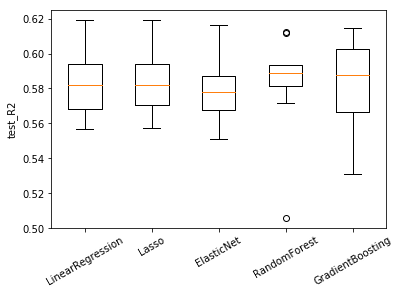

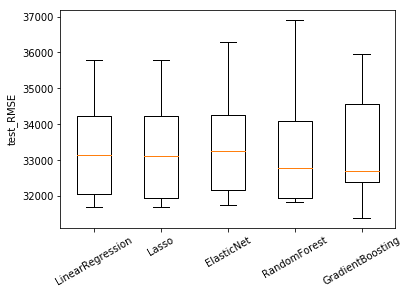

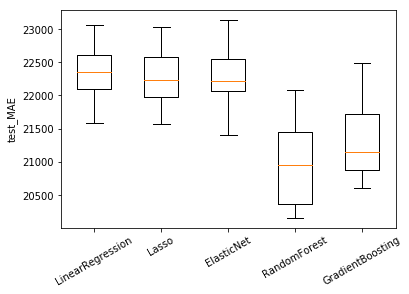

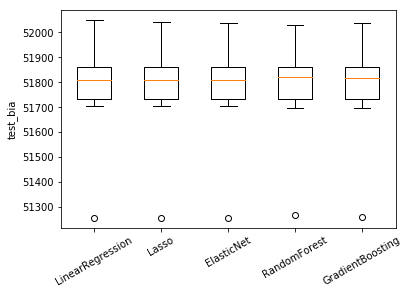

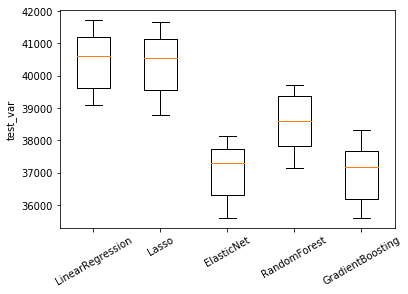

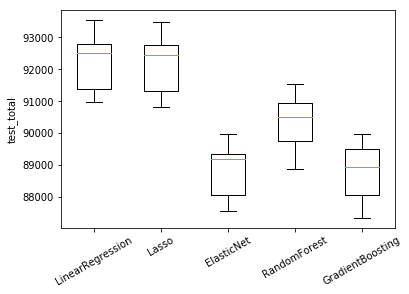

In [46]:
all_score = [lr_score,lasso_score,elc_score,rfr_score,gdb_score]
xlabels = ['LinearRegression','Lasso','ElasticNet','RandomForest','GradientBoosting']
ylabels = all_score[0].columns
for i in range(len(ylabels)):
    if not i%2:
        continue
    score = [j.iloc[:,i] for j in all_score]
    plt.figure()
    plt.ylabel(ylabels[i])
    plt.boxplot(score, labels=xlabels)
    plt.xticks(rotation=30)
    plt.show()
all_trade = [lr_trade,lasso_trade,elc_trade,rfr_trade,gdb_trade]
ylabels = all_trade[0].columns
for i in range(len(ylabels)):
    if not i%2:
        continue
    score = [j.iloc[:,i] for j in all_trade]
    plt.figure()
    plt.ylabel(ylabels[i])
    plt.boxplot(score, labels=xlabels)
    plt.xticks(rotation=30)
    plt.show()

# Q5 Model Tuning

In [47]:
lr_bestmodel, lr_bestscore = LeFeatureReg.train_model('LinearRegression',ifhyper_tune=True)

Through Hypertuning on LinearRegression, we get the best model and the results below:
The R2 score is 0.609853710186478
The RMSE score is 32337.127780446463
The MAE score is 21622.296833343207


In [48]:
lasso_bestmodel, lasso_bestscore = LeFeatureReg.train_model('Lasso',ifhyper_tune=True)

The best score of model Lasso through 5-cross validation is 0.5843448336186001, with the best hyper-parameter {'alpha': 14.5}

Through Hypertuning on Lasso, we get the best model and the results below:
The R2 score is 0.6098225088872025
The RMSE score is 32338.420808544208
The MAE score is 21605.43155156721


In [ ]:
elc_bestmodel, elc_bestscore = LeFeatureReg.train_model('ElasticNet',ifhyper_tune=True)

/home/hanwen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/hanwen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/hanwen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/hanwen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not co

The best score of model ElasticNet through 5-cross validation is 0.5841288359477519, with the best hyper-parameter {'l1_ratio': 1.0}

Through Hypertuning on ElasticNet, we get the best model and the results below:
The R2 score is 0.6098534710788768
The RMSE score is 32337.137689616527
The MAE score is 21621.014060771402


In [ ]:
rfr_bestmodel, rfr_bestscore = LeFeatureReg.train_model('RandomForest',ifhyper_tune=True)

In [ ]:
gdb_bestmodel, gdb_bestscore = LeFeatureReg.train_model('GradientBoosting',ifhyper_tune=True)

# Q6 Testing & Discussion

In [ ]:
print("For model LinearRegrssion, the training results of best model is listed below:")
ls_besttrn_result = LeFeatureReg.test_model(LX_Train,Y_Train,lr_bestmodel)
print("The testing results of best model is listed below:")
ls_besttst_result = LeFeatureReg.test_model(LX_Test,Y_Test,lr_bestmodel)

In [ ]:
print("For model Lasso, the training results of best model is listed below:")
lasso_besttrn_result = LeFeatureReg.test_model(LX_Train,Y_Train,lasso_bestmodel)
print("The testing results of best model is listed below:")
lasso_besttst_result = LeFeatureReg.test_model(LX_Test,Y_Test,lasso_bestmodel)

In [ ]:
print("For model ElasticNet, the training results of best model is listed below:")
elc_besttrn_result = LeFeatureReg.test_model(X_Train,Y_Train,elc_bestmodel)
print("The testing results of best model is listed below:")
elc_besttst_result = LeFeatureReg.test_model(X_Test,Y_Test,elc_bestmodel)

In [ ]:
print("For model RandomForest, the training results of best model is listed below:")
rfr_besttrn_result = LeFeatureReg.test_model(X_Train,Y_Train,rfr_bestmodel)
print("The testing results of best model is listed below:")
rfr_besttst_result = LeFeatureReg.test_model(X_Test,Y_Test,rfr_bestmodel)

In [ ]:
print("For model GradientBoosting, the training results of best model is listed below:")
gdb_besttrn_result = LeFeatureReg.test_model(X_Train,Y_Train,gdb_bestmodel)
print("The testing results of best model is listed below:")
gdb_besttst_result = LeFeatureReg.test_model(X_Test,Y_Test,gdb_bestmodel)